In [1]:
%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import util
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared, DotProduct, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
import os
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

# Load data
data_folder = os.path.join('..', 'data', 'nab')
file_name = os.path.join('realTraffic', 'occupancy_6005.csv')
data, labels, windows = util.load_series(file_name, data_folder)
data_d = ddata = data.resample('5min').mean()

# Filling Missing Values in Traffic Data

## Back to the Traffic Data

**We will try to use a Gaussian Process on our new traffic data**

We will start directly from the dense series:

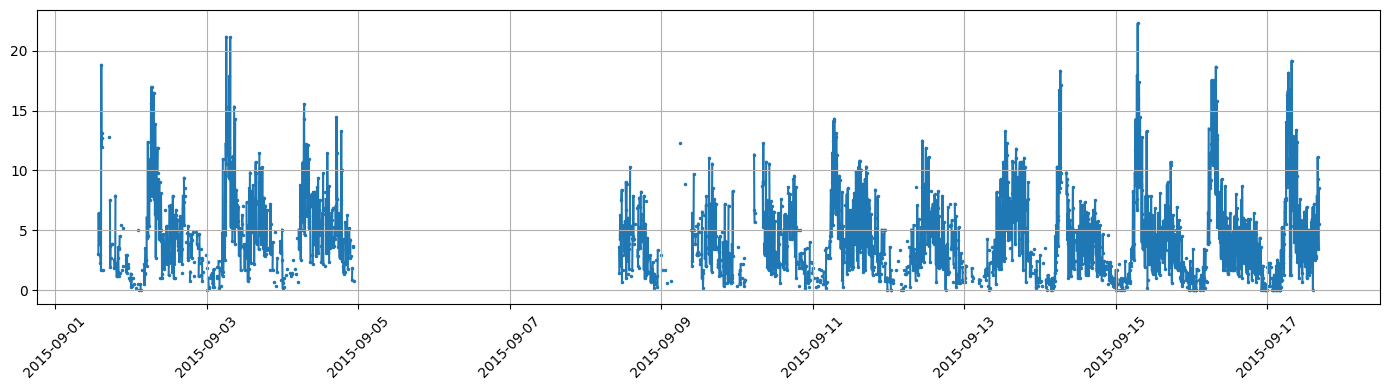

In [2]:
util.plot_series(data_d, show_markers=True, figsize=figsize)

* There is a _period_, _non-zero mean_, local _oscillations_. And of course a _huge gap_

## Time and Period

**The input of the GP is going to be the _time_ of the observation**

Unfortunately, the GP in scikit-learn cannot handle `DateTime` objects

* Therefore, we will convert all time steps in numeric format
* We will use a simple time equivalent, namely 1 step = 1 time unit

In [3]:
data_dt = data_d.copy()
data_dt['time'] = np.arange(len(data_dt))

**Before we start, it would be very useful to estimate the period**

Due to the missing values, the series has a _non-uniform sampling frequency_

* Autocorrelation plots cannot be used in this case
* The standard FFT is also not applicable (we could use a [non-uniform FFT](https://en.wikipedia.org/wiki/Non-uniform_discrete_Fourier_transform))

**Thankfully, this is traffic data! So we can bet there is _a weekly period_**

## Process Outline

**We have no ground truth: how are we going to evaluate the kernels?**

We will use the same trick we used before:

* We will _focus on a portion_ of our sequence
    * ...One with relatively few missing values
* Then we will _artificially remove_ part of the data points
    * This will form the ground truth for our evaluation

Main idea: use _part of our data as a validation set_

**Which quality metric?**

* Thanks to the availability of confidence intervals...
* ...We can compute the _likelihood_ of our validation set!
* Using the MSE would do the same, only with more assumptions

## Training and Validation Data

**We will use for training (and validation) this stretch of the series**

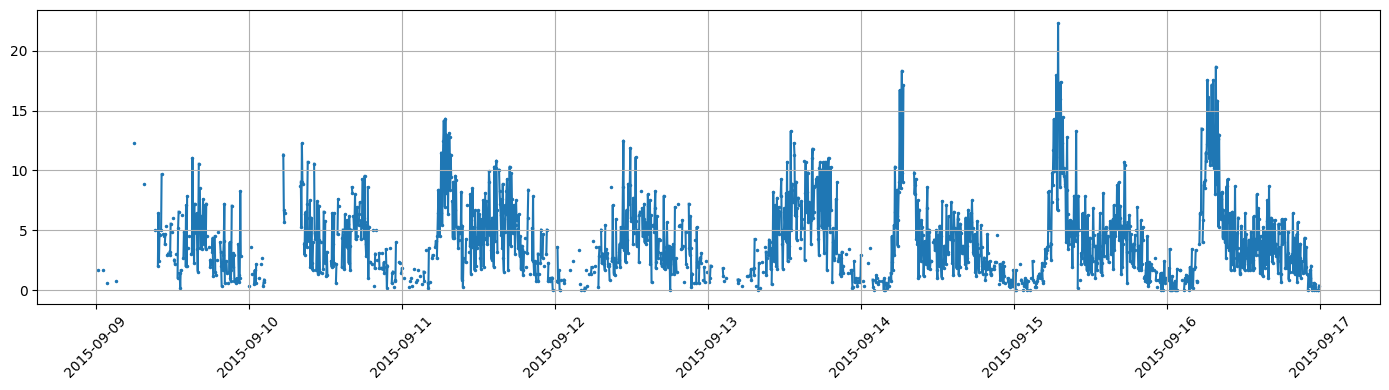

In [4]:
segment = data_dt[(data_dt.index >= '2015-09-09') & (data_dt.index < '2015-09-17')].copy()
util.plot_series(segment['value'], show_markers=True, figsize=figsize)

* We made sure to include _at least one full week_

## Training and Validation Data

**We can now separate training and validation data:**

In [5]:
tmp = segment.dropna()

np.random.seed(42)
idx = np.arange(len(tmp))
np.random.shuffle(idx[1:-1]) # no not shuffle the first/last point
t = idx[1]; idx[1] = idx[-1]; idx[-1] = t # keep first/last points in the left half

sep = 2*len(idx) // 3
trdata = tmp.iloc[idx[:sep]]
tsdata = tmp.iloc[idx[sep:]]

* We are keeping 2/3 of the data for training
* Since we are using the dense series, we need to discard NaNs (`dropna`)
* Since we are doing interpolation...
* ...It's a good idea to keep the first and last point in the training set

## A Starting Kernel

**Let's try with a relatively simple kernel**

In [6]:
kernel = WhiteKernel(1e-3, (1e-4, 1e-1))
kernel += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-1, 1e1))

np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(trdata[['time']], trdata['value'])
print(gp.kernel_)

WhiteKernel(noise_level=0.1) + 4.86**2 * RBF(length_scale=1.07)


Then we obtain the predictions:

In [7]:
pred, std = gp.predict(segment[['time']], return_std=True)
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

## A Starting Kernel

**Let's have a look at the predictions**

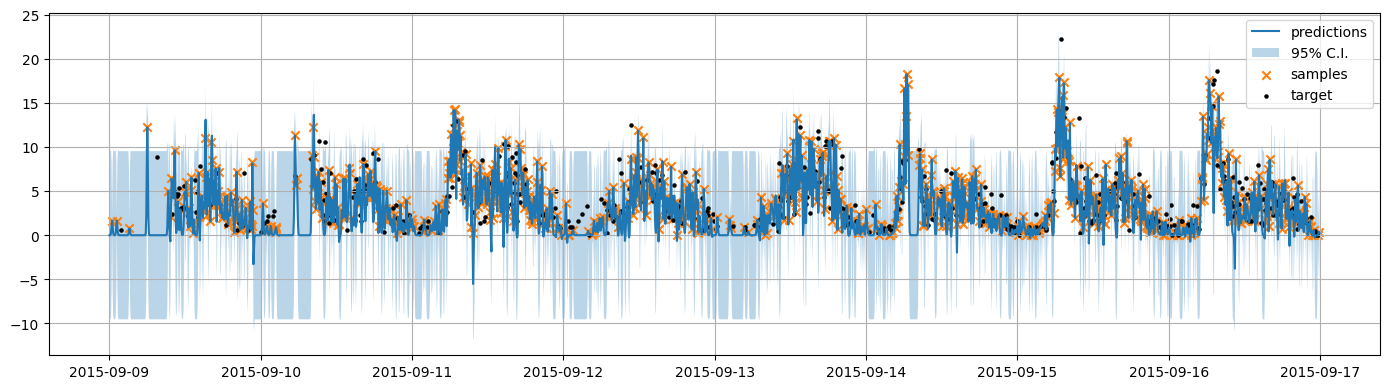

In [8]:
util.plot_gp(target_samples=tsdata['value'], samples=trdata['value'], pred=pred, std=std, figsize=figsize)

* Not so bad, but not so good either
* We have _very wide confidence intervals!_

## A Starting Kernel

**Let's compute the (log) likelihood of the validation data**

In [9]:
from scipy.stats import norm

# Obtain predictions for the validation data
pred_ts = pred[tsdata.index]
std_ts = std[tsdata.index]

ldens = norm.logpdf(tsdata['value'], pred_ts, std_ts)
ll = np.sum(ldens)
print(f'Log likelihood of the validation set: {ll:.2f}')

Log likelihood of the validation set: -1377.62


* This is our reference value
* We will try to beat it by _improving the kernel_

## A Second Kernel

**Let's add _the period_**

We can choose the bounds so as to focus on a weekly period

In [10]:
kernel = WhiteKernel(1e-3, (1e-4, 1e-1))
kernel += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-1, 1e1))
kernel += ConstantKernel(1, (1e-2, 1e2)) * ExpSineSquared(1, 2000, (1e-1, 1e1), (1900, 2100))

np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(trdata[['time']], trdata['value'])
print(gp.kernel_)

WhiteKernel(noise_level=0.0213) + 2.02**2 * RBF(length_scale=0.1) + 5.37**2 * ExpSineSquared(length_scale=0.1, periodicity=2.01e+03)


Then we obtain the new predictions:

In [11]:
pred, std = gp.predict(segment[['time']], return_std=True)
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

## A Second Kernel

**Both predictions and likelihood are now better**

Log likelihood of the validation set: -1110.69


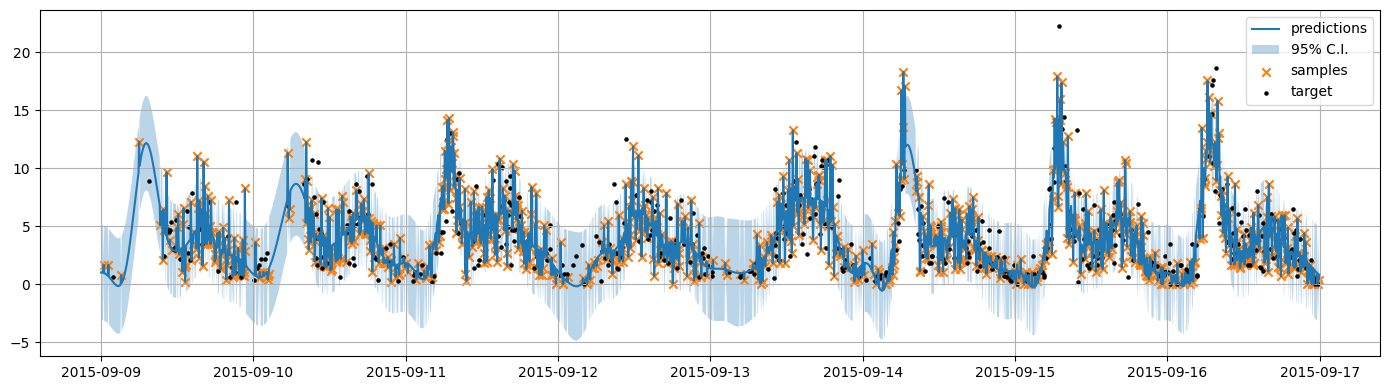

In [12]:
util.plot_gp(target_samples=tsdata['value'], samples=trdata['value'], pred=pred, std=std, figsize=figsize)
ldens = norm.logpdf(tsdata['value'], pred[tsdata.index], std[tsdata.index])
print(f'Log likelihood of the validation set: {np.sum(ldens):.2f}')

* ...But the confidence intervals are still large

## Transferring the Results

**We now need to obtain predictions _for the whole series_**

We would prefer to _avoid training again the kernel_ parameters

* The large number of missing value may be problematic
* ...And the training time would be very large

...But we _also_ really wish to use _all available observations_

* ...Not just those considered when training the kernel

**With Gaussian Processes, we can do both**

There is _no need to train again the kernel_ every time new observations arrive

* We can build a new $\Sigma$ matrix using _the new observations_ and _the old kernel_

## Transferring the Results

**We _reuse the kernel_ by passing it as argument when building a new GP:**

In [13]:
gp2 = GaussianProcessRegressor(kernel=gp.kernel_, optimizer=None)

Passing `optimizer=None` will _disable optimization_ at training time

**So that calling `fit` will just take into account _a new set of observations_**

In [14]:
tmp = data_dt.dropna() # The whole series (NaNs excluded)
gp2.fit(tmp[['time']], tmp['value']);

Now we can obtain predictions for the whole series:

In [15]:
pred_all, std_all = gp2.predict(data_dt[['time']], return_std=True)
pred_all = pd.Series(index=data_dt.index, data=pred_all)
std_all = pd.Series(index=data_dt.index, data=std_all)

## Transferring the Results

**Let's have a look at all the predictions**

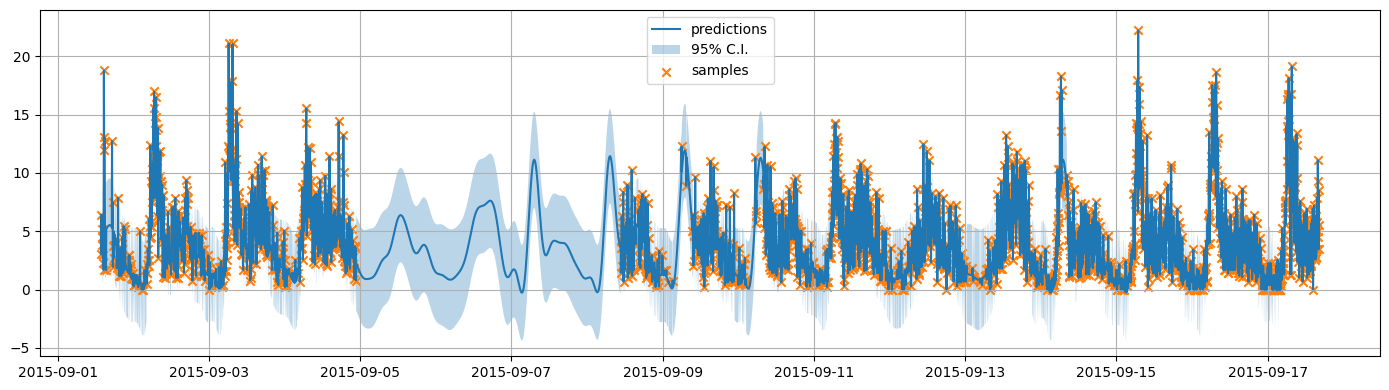

In [16]:
util.plot_gp(samples=data_dt['value'], pred=pred_all, std=std_all, figsize=figsize)

* We actually managed to (partially) reconstruct _even the large gap_!
* ....But we _still_ have those large confidence intervals

## Transferring the Results

**The confidence intervals are still very large**

* This is in part understandable, give the presence of wide variations
* ...But at least one point is a bit strange

**The confidence intervals are large _even for the night hours_!**

There are two reasons:

* There are _fewer samples_ at nighttime
    * As we get far from the samples the confidence drops (quickly, in our case)
* No traditional GP kernel can represent _input-dependent variance_
    * All kernels are about covariance, not variance
    * The lone exception is the `WhiteKernel`, which is not input dependent

**Can we deal with this issues?**

# Standard Deviation Model

## Multiplicative Ensemble

**We can deal with the input-dependent variance _in a separate model_**

We are going to build an _ensemble_ of predictive models

* Classical ensembles (e.g. Random Forests, Gradient Boosting) are based on _sums_
* But that's not going to work with variance, since:

$$
\mathit{Var}(x + \alpha) = \mathit{Var}(x)
$$

**However, variance can be _scaled via multiplication_:**

In particular:

$$
\mathit{Var}(\alpha x) = \alpha^2 \mathit{Var}(x)
$$

* So we can use _a "multiplicative" ensemble_

## Multiplicative Ensemble

**Our model will become _the product of two models_**

Formally, we will have:

$$ 
g(x, \lambda) f(x, \theta)
$$

* $f$, with parameters $\theta$ will be a Gaussian Process
* $g$, with parameters $\lambda$ will be our _variance model_ (or _standard deviation model_)

**On the training set, we wish to have:**

$$
g(x_i, \lambda) f(x_i, \theta) \simeq y_i \quad\Rightarrow\quad f(x_i, \theta) \simeq \frac{y_i}{g(x_i, \lambda)}
$$

* The Gaussian Process will need to learn a series with a variance _altered by $g$_
* The variance of each point $y_i$ will be divided by $g(x_i, \lambda)^2$


## Standard Deviation Model

**We now need to choose our variance model $g$**

* Since we have discrete time and a natural period (a week)
* ...We could use a simple map (time of the week $\rightarrow$ standard deviation)

**Let's add a "hour of the week" information to our data:**

The chosen time unit is actually irrelevant

In [17]:
data_dtw = data_dt.copy()
data_dtw['how'] = 24 * data_dt.index.weekday + data_dt.index.hour + data_dt.index.minute / 60
data_dtw.head()

,value,time,how
timestamp,,,
2015-09-01 13:45:00,3.06,0,37.750000
2015-09-01 13:50:00,6.44,1,37.833333
2015-09-01 13:55:00,5.17,2,37.916667
2015-09-01 14:00:00,3.83,3,38.000000
2015-09-01 14:05:00,4.50,4,38.083333


## Standard Deviation Model

**Then we can compute the standard deviation via a pandas `groupby` operation:**

In [18]:
how_std = data_dtw.groupby('how').agg({'value': ['std', 'count']})

* `agg` allows to apply multiple aggregation functions to multiple columns

**The resulting table has a _hierarchical column index_**

Let's see some statistics about the value counts:

In [19]:
how_std['value', 'count'].describe() # Notice the use of two names

count    2016.000000
mean        1.177083
std         0.850567
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: (value, count), dtype: float64

## Standard Deviation Model

**Let's have a look at the _standard deviation_ values**

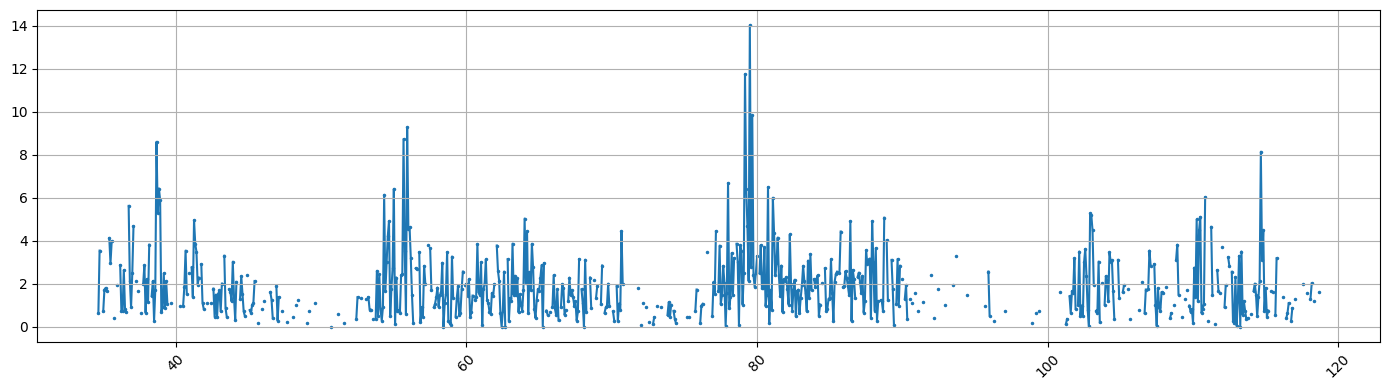

In [20]:
util.plot_series(how_std['value', 'std'], show_markers=True, figsize=figsize)

* There are _many missing values_ (as expected from the counts)!
* Note: this is a time-to-stdev map, not our original series!

## Choosing the Correct Interval

**There are too many gaps in our data to compute $\sigma$ with this granularity**

There are a few possible solutions:

* _Filling the gaps_ also in the standard deviation data
* ...Or using _a coarser time unit_
* ...Or choosing _a shorter period_ (e.g. one day)

**Let's try using hour-long intervals (rather than 5 minutes)**

In [21]:
data_dtw = data_dt.copy()
data_dtw['how'] = np.round(24 * data_dt.index.weekday + data_dt.index.hour + data_dt.index.minute / 60)
how_std = data_dtw.groupby('how').agg({'value': ['std', 'count']})

* We need to check that _no std value is missing_
* ...But also that _the counts are large enough_ for a reliable computation

## Choosing the Correct Interval

**Let's look again at the standard deviation values**

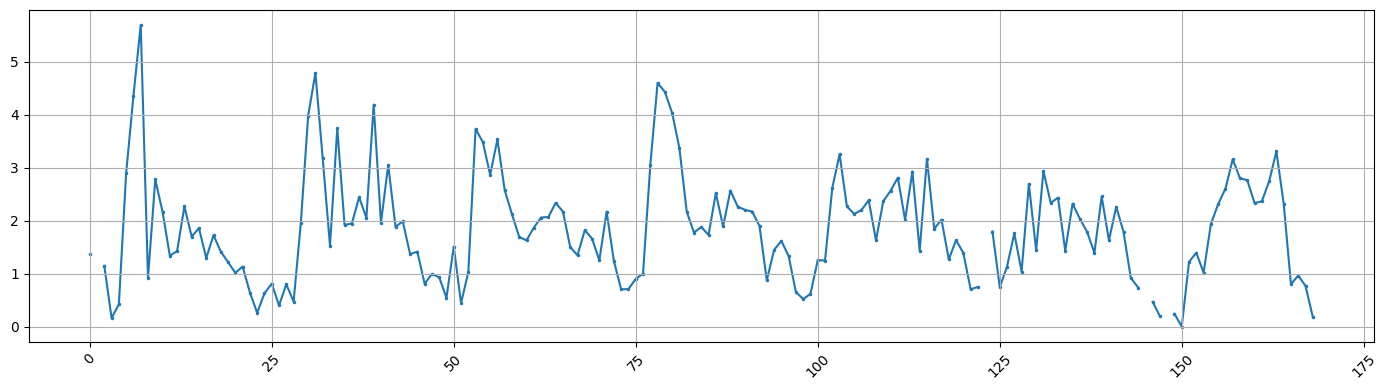

In [22]:
util.plot_series(how_std['value', 'std'], show_markers=True, figsize=figsize)

* There are _still a few gaps_

## Choosing the Correct Interval

**...And let's see the value counts**

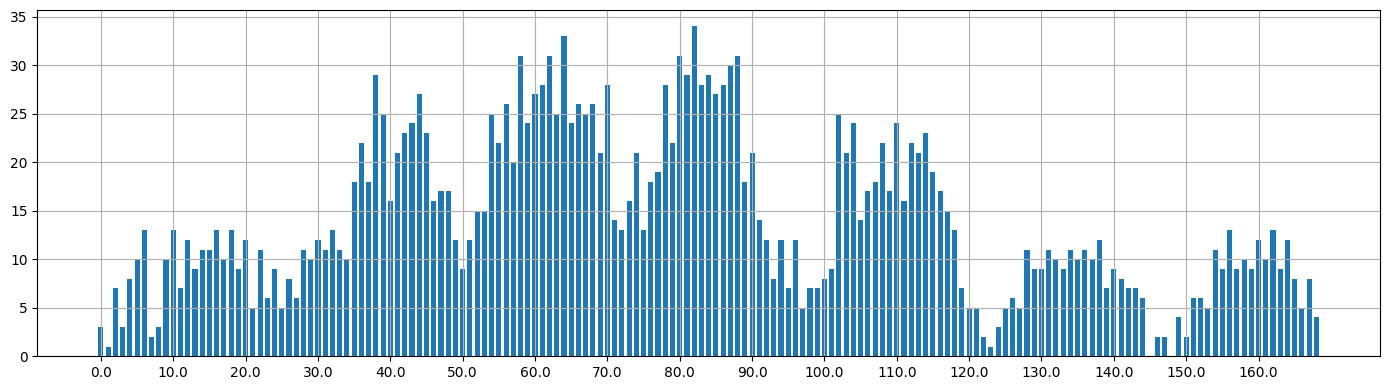

In [23]:
util.plot_bars(how_std['value', 'count'], figsize=figsize)

* Several value counts are too low for $\sigma$ to be reliable

## Choosing the Correct Interval

**We can try again with two-hour intervals**

In [24]:
data_dtw = data_dt.copy()
data_dtw['how'] = 2*np.round(0.5*(24 * data_dt.index.weekday + data_dt.index.hour + data_dt.index.minute / 60))
how_std = data_dtw.groupby('how').agg({'value': ['std', 'count']})

**Let's check some information about the value counts:**

* Ideally, we wish them at $\sim 30$

In [25]:
how_std['value', 'count'].describe()

count    85.000000
mean     27.917647
std      16.132791
min       3.000000
25%      16.000000
50%      22.000000
75%      42.000000
max      63.000000
Name: (value, count), dtype: float64

## Choosing the Correct Interval

**Let's look the standard deviation with two-hour intervals**

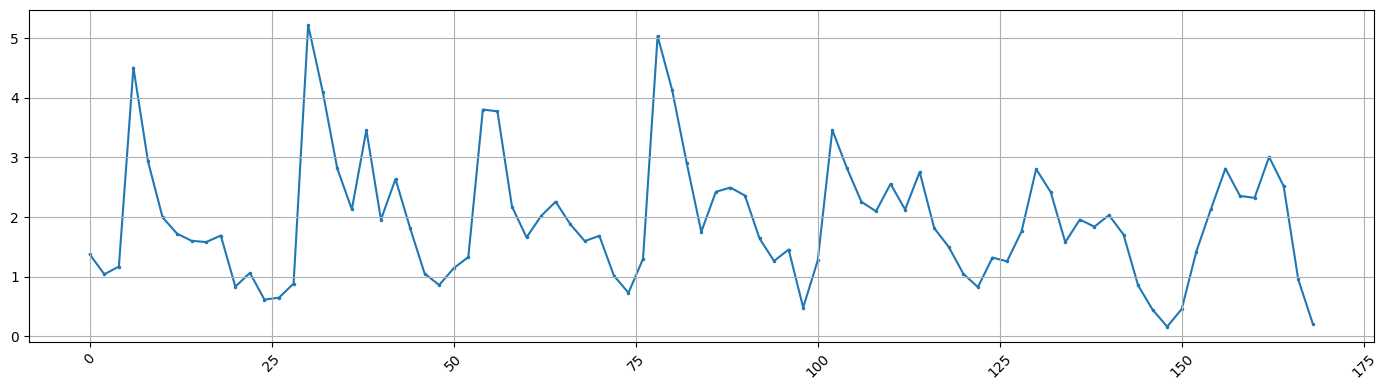

In [26]:
util.plot_series(how_std['value', 'std'], show_markers=True, figsize=figsize)

* Finally, _no more missing values_ and _decently large counts_

## Upsampling and Smoothing

**We managed to have reasonable standard deviation values..**

...But out map/table has a _very_ coarse time unit!

* Using it would lead to _sharp variations_ in our predicted standard deviation

**We will now proceed to mitigate the problem**

We will start by _upsampling_, i.e. switching to a finer grain time unit:

In [27]:
how_values = np.unique(24 * data_dt.index.weekday + data_dt.index.hour + data_dt.index.minute / 60)
how_std_d = pd.DataFrame(index=sorted(how_values), columns=['std'], data=np.nan)
how_std_d['std'] = how_std['value', 'std']

This process leads to many missing values, that we fill via _linear interpolation_:

In [28]:
how_std_di = how_std_d.interpolate(method='linear')

## Upsampling and Smoothing

**Let's see the oversampled series**

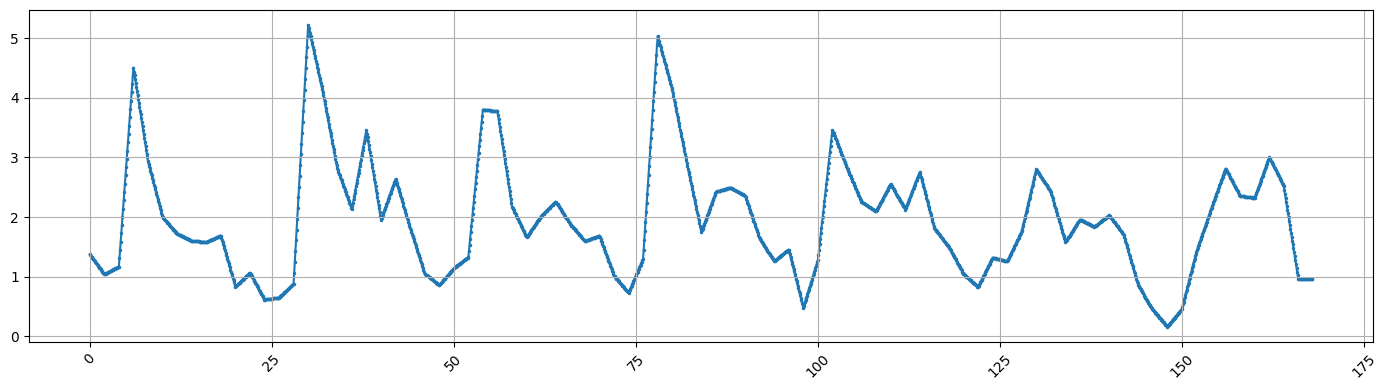

In [29]:
util.plot_series(how_std_di['std'], show_markers=True, figsize=figsize)

* The plot is the same as before, but there are _more values on the x-axis_

## Upsampling and Smoothing

**We will smooth the cuve via a simple low-pass filter**

I.e. the _Exponentially Weighted Moving Average_

* This is a form of discrete filter, given by the recursion:
$$s
s_i = \left\{\begin{aligned}
& x_i & \text{ if } i = 1 \\
& \alpha x_i + (1 - \alpha) s_{i-1} & \text{ otherwise}
\end{aligned}\right.
$$
* $s_i$ is the $i$-th element of the output (smoothed) series
* $\alpha$ is called the _smoothing factor_ and is equal to $1 / (1 + \tau)$

**Why not using a simple moving average?**

* A moving average gives the same weigth to all observations...
* ...whereas in our case _"recent" observations are more important_
* I.e. the stdev from the original table should still be the dominant value


## Upsampling and Smoothing

**In pandas, we can use the [`ewm`]((https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html)) iterator, plus the `mean` aggregation function**

```python
DataFrame.ewm(com=None, ...).mean()
```

* The `com` parameter corresponds to $\tau$

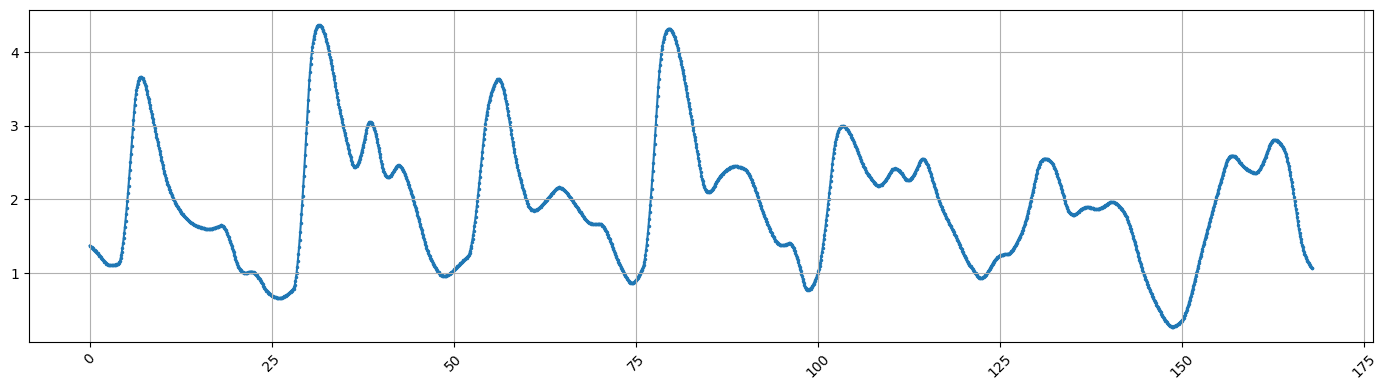

In [30]:
how_std_ds = how_std_di[['std']].ewm(com=12).mean()
util.plot_series(how_std_ds['std'], show_markers=True, figsize=figsize)

* We chose $\tau = $ the number of time steps in one hour

# Gaussian Process for the Ensemble

## Transforming the Dataset

**We can now learn the Gaussian Process for our Ensemble**

For this, we need to _transform the original series_ using the stdev model

* We start by augmenting our dataset with the "hour of the week information"
* ...Then, we associate each data point to the predicted standard deviation

In [31]:
data_dt['how'] = 24 * data_dt.index.weekday + data_dt.index.hour + data_dt.index.minute / 60
data_dts = data_dt.join(how_std_ds, on='how')
data_dts.head()

,value,time,how,std
timestamp,,,,
2015-09-01 13:45:00,3.06,0,37.750000,2.822412
2015-09-01 13:50:00,6.44,1,37.833333,2.862934
2015-09-01 13:55:00,5.17,2,37.916667,2.904604
2015-09-01 14:00:00,3.83,3,38.000000,2.947336
2015-09-01 14:05:00,4.50,4,38.083333,2.981964


* We relied on the [`join` method from `pandas`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html)

## Transforming the Dataset

**Now we can actually transform the series values**

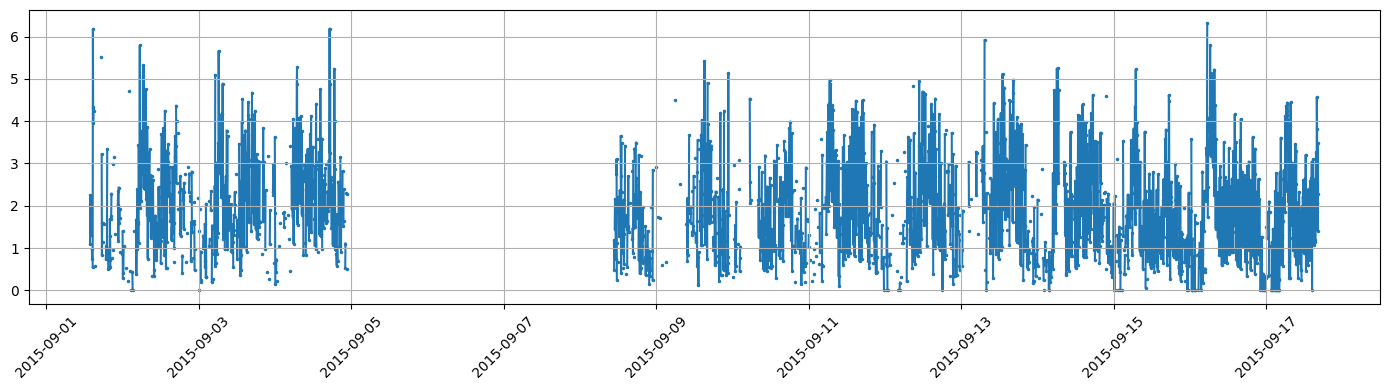

In [32]:
data_dts['value_tr'] = data_dts['value'] / data_dts['std']
util.plot_series(data_dts['value_tr'], show_markers=True, figsize=figsize)

* The series _has changed considerably_: this is not a simple standardization

## Training Data

**We can now select a sub-sequence of the data for learning the kernel**

...Which is necessary, since the data has changed!

In [33]:
segment_s = data_dts[(data_dts.index >= '2015-09-09') & (data_dts.index < '2015-09-17')].copy()

We separate training and validation data as we did  before:

In [34]:
tmp = segment_s.dropna()

np.random.seed(42)
idx = np.arange(len(tmp))
np.random.shuffle(idx[1:-1]) # no not shuffle the first/last point
t = idx[1]; idx[1] = idx[-1]; idx[-1] = t # keep first/last points in the left half

sep = 2*len(idx) // 3
trdata_s = tmp.iloc[idx[:sep]]
tsdata_s = tmp.iloc[idx[sep:]]

## Learning the Kernel Parameters

**We can now learn the kernel parameters**

We can use the same starting parameters (_priors_) as before:

In [35]:
kernel_s = WhiteKernel(1e-3, (1e-4, 1e-1))
kernel_s += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-1, 1e1))
kernel_s += ConstantKernel(1, (1e-2, 1e2)) * ExpSineSquared(1, 2000, (1e-1, 1e1), (1900, 2100))

np.random.seed(42)
gp_s = GaussianProcessRegressor(kernel=kernel_s, n_restarts_optimizer=3)
gp_s.fit(trdata_s[['time']], trdata_s['value_tr'])
print(gp_s.kernel_)

WhiteKernel(noise_level=0.000153) + 0.91**2 * RBF(length_scale=0.447) + 1.66**2 * ExpSineSquared(length_scale=0.103, periodicity=2.01e+03)


Then we obtain the predictions:

In [36]:
pred_s, std_s = gp_s.predict(segment_s[['time']], return_std=True)
pred_s = pd.Series(index=segment_s.index, data=pred_s)
std_s = pd.Series(index=segment_s.index, data=std_s)

## Learning the Kernel Parameters

**Let's look at the predictions on the training data**

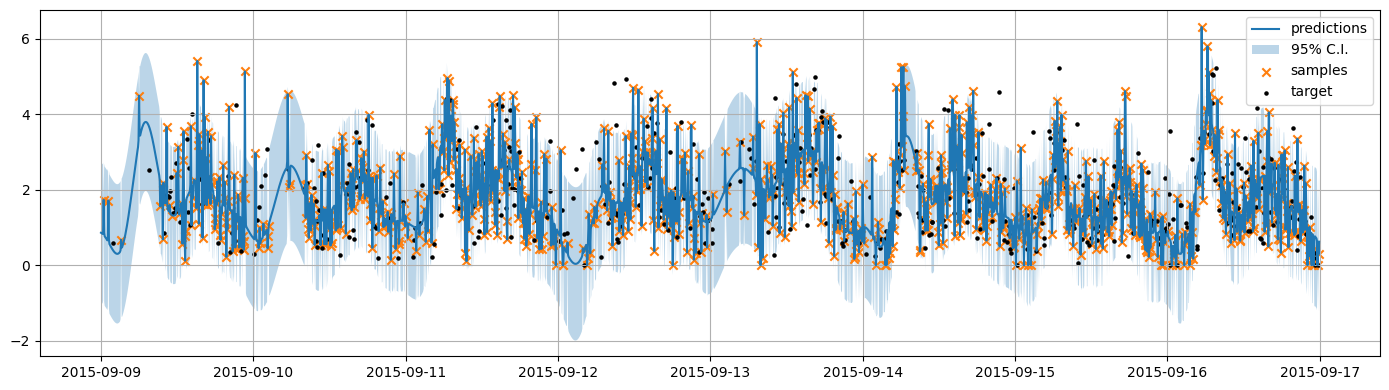

In [37]:
util.plot_gp(target_samples=tsdata_s['value_tr'], samples=trdata_s['value_tr'], pred=pred_s, std=std_s, figsize=figsize)

* For sake of simplicity, we will not try to improve the kernel

## Transferring the Results

**Now we obtain predictions for the missing values in the _transformed_ series**

Again, we reuse the kernel and add the observations:

In [38]:
gp2_s = GaussianProcessRegressor(kernel=gp_s.kernel_, optimizer=None)
tmp_s = data_dts.dropna() # The whole series (NaNs excluded)
gp2_s.fit(tmp_s[['time']], tmp_s['value_tr']);

Then we can obtain predictions (and confidence intervals) for the whole series

In [39]:
pred_all_s, std_all_s = gp2_s.predict(data_dts[['time']], return_std=True)
pred_all_s = pd.Series(index=data_dts.index, data=pred_all_s)
std_all_s = pd.Series(index=data_dts.index, data=std_all_s)

* Of course are still referring to the transformed series

## Transferring the Results

**Let's have a look at all the predictions**

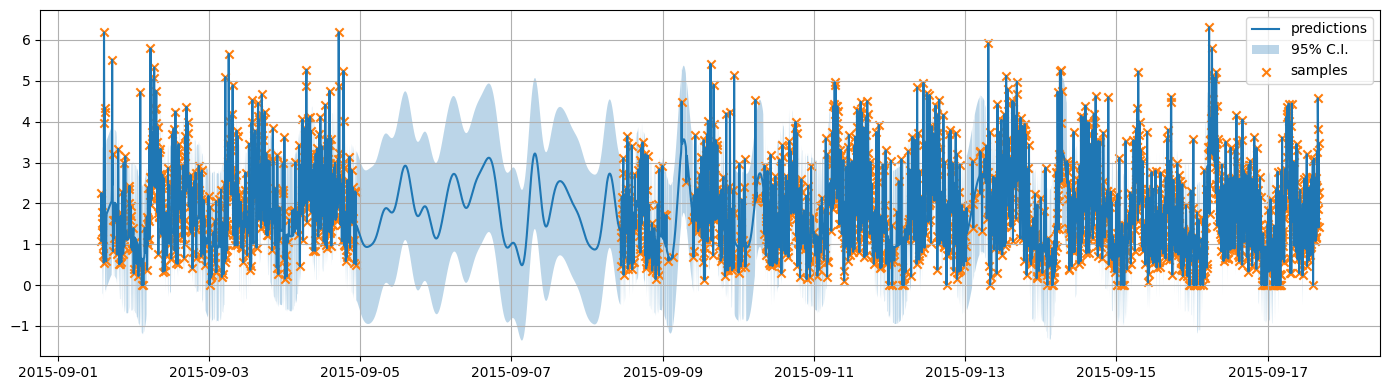

In [40]:
util.plot_gp(samples=data_dts['value_tr'], pred=pred_all_s, std=std_all_s, figsize=figsize)

* They are not so easy to interpret, since they refer to the transformed series

## Predictions for the Original Series

**We obtain predictions _for the original series_ by injecting back the variance**

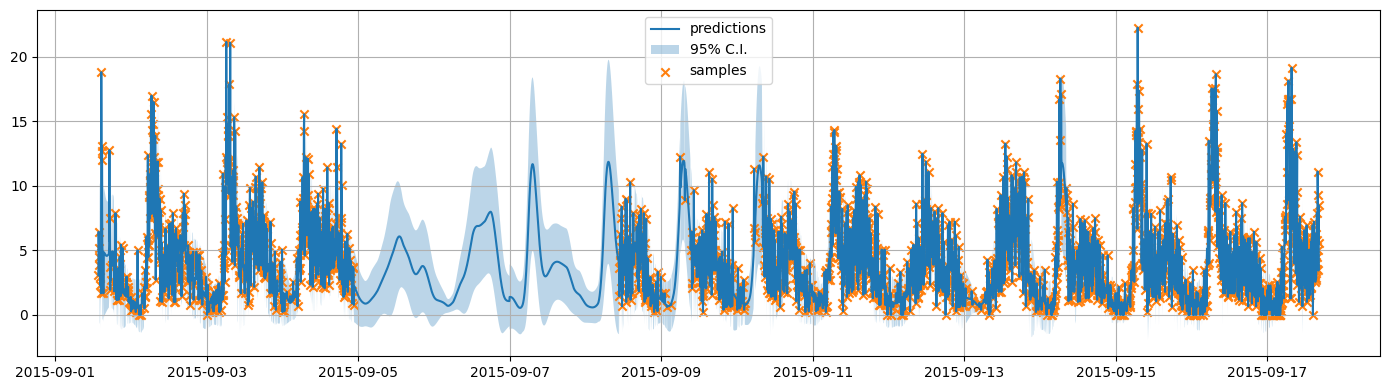

In [41]:
pred_all2_s = pd.Series(index=data_dts.index, data=pred_all_s * data_dts['std'])
std_all2_s = pd.Series(index=data_dts.index, data=std_all_s * data_dts['std'])
util.plot_gp(samples=data_dt['value'], pred=pred_all2_s, std=std_all2_s, figsize=figsize)

* Due to the properties of variance
* ...We can _just multiply also the standard deviation_

## Predictions for the Original Series

**For comparison, here are the results for the previous Gaussian Process**

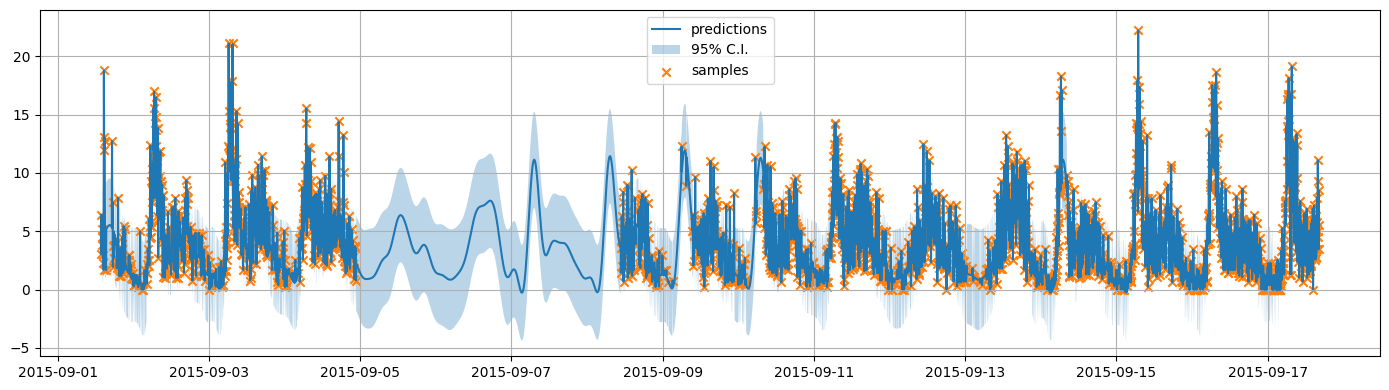

In [42]:
util.plot_gp(samples=data_dt['value'], pred=pred_all, std=std_all, figsize=figsize) 

* The new confidence intervals are _much tighter_

## Fill with Predictions and Samples

**We can fill the missing values using the _predictions_**

This will fill each missing value using the Maximum A Posteriori

In [43]:
mask = data_d['value'].isnull() # we need to fill only the NaNs
data_filled_pred = data_d.copy()
data_filled_pred.loc[mask, 'value'] = np.maximum(0, pred_all2_s[mask])

**But with GPs, we can also _sample from the distribution_**

In [44]:
tmp = data_dts[mask]
sample_ms = gp2_s.sample_y(tmp[['time']], random_state=42).ravel()
data_filled_samples = data_d.copy()
data_filled_samples.loc[mask, 'value'] = np.maximum(0, sample_ms * tmp['std'])

* `sample_y` returns a matrix: we used `ravel` to have a single dimension
* In both cases, we _clip values at zero_ (no less than 0 occupancy)

## Filling with Predictions and Samples

**Here's the series filled _using predictions_:**

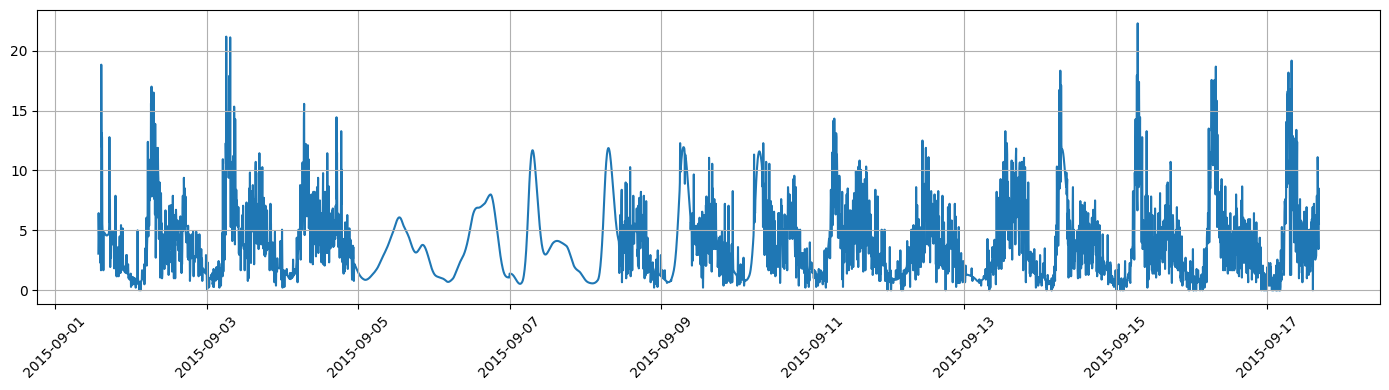

In [45]:
util.plot_series(data_filled_pred, figsize=figsize)

* The use of MAPs is evident in the large gap

## Filling with Predictions and Samples

**Here's the series filled _using samples_:**

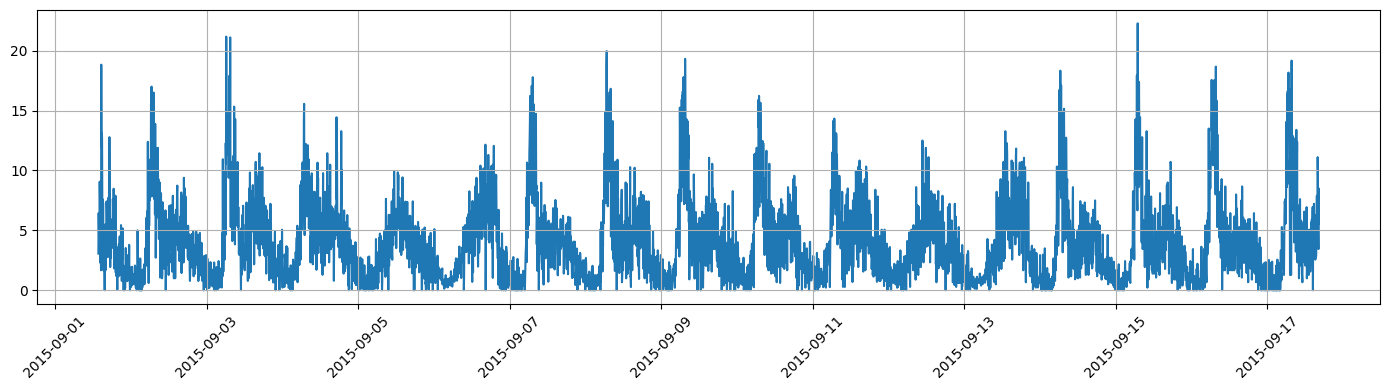

In [46]:
util.plot_series(data_filled_samples, figsize=figsize)

* There no evidently "fake" sections, now! ...Except for the effect of clipping at 0